# Arquivo criado para classificar base de dados com foco na profissão do investidor

## Instalacao bibliotecas necessarias

In [1]:
# !pip install catboost
# !pip install xgboost

## 1. Extracao da base de dados

In [2]:
# Imports e leitura
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta

In [3]:
df_principal = pd.read_parquet("./data/to_classify/sample_data_cluster.parquet")  #index_col=0)
df = df_principal #df_principal[df_principal['Macrogrupo_Profissao'] != 'Outros']

alvo = 'Cluster'

# df['target'] = df['UF do Investidor'] + '_' + df['Macrogrupo_Profissao']

counts = df[alvo].value_counts()
df = df[df[alvo].isin(counts[counts >= 30].index)]

In [94]:
# Operar no 12 meses e nao teve adesao nos ultimos 12 meses

# Converter a coluna 'Data de Adesao' para datetime
df['Data de Adesao'] = pd.to_datetime(df['Data de Adesao'], format='%d/%m/%Y', errors='coerce')

# Filtrar as linhas onde a data de adesão não está nos últimos 12 meses
doze_meses_atras = datetime.now() - timedelta(days=365)
df = df[df['Data de Adesao'] < doze_meses_atras]

df['Data de Adesao'] = df['Data de Adesao'].astype(str)

In [95]:
# Criando o novo atributo 'Conta_Ativa'
df['Conta_Ativa'] = ((df['Operou 12 Meses'] == 'S') ).astype(int)

# Verificando o resultado
df['Conta_Ativa'].value_counts()

Conta_Ativa
0    88392
1     6393
Name: count, dtype: int64

In [69]:
df[['Genero']].value_counts()

Genero
1         66265
0         28143
2           377
Name: count, dtype: int64

## 2. Transformacao dos dados

In [82]:
# Encoding de variáveis categóricas (transformado em numeros inteiros)
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


X = df.drop(columns=['UF do Investidor', 'Profissao', alvo,'Conta_Ativa'])

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_cols = ['Macrogrupo_Profissao', 'Estado Civil', 'Genero', 'Cidade do Investidor', 'Pais do Investidor', 'Situacao da Conta', 'Operou 12 Meses', 'Faixa Etária']

ct = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # mantém as colunas numéricas
)

X_transformed = ct.fit_transform(X)


y = df['Conta_Ativa'] #df[['UF do Investidor', 'Profissao']]
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3, random_state=42, stratify=y) #70% Treino e 30%Teste

## 3. Treinamento e analise de modelos

### 3.1 Treinamento

In [88]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

# Decision Tree
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)
pred_dt = dt.predict(X_test)
print("Treinamento com arvore de decisao finalizado")
print("Acurácia Decision Tree:", accuracy_score(y_test, pred_dt))

# Random Forest
rf = RandomForestClassifier(n_estimators=100,max_depth=3)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print("Treinamento com arvore de decisao aleatoria finalizado")
print("Acurácia Random Forest:", accuracy_score(y_test, pred_rf))

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss',n_estimators=100,max_depth=3,learning_rate=0.2, tree_method='gpu_hist')
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
print("Treinamento com XGBOOST finalizado")
print("Acurácia XGBoost:", accuracy_score(y_test, pred_xgb))

# CatBoost
# cb = CatBoostClassifier(verbose=0, task_type="GPU")
# cb.fit(X_train, y_train)
# pred_cb = cb.predict(X_test)
# print("Treinamento com CATBOOST finalizado")

# Avaliação
print("Acurácia Decision Tree:", accuracy_score(y_test, pred_dt))
print("Acurácia Random Forest:", accuracy_score(y_test, pred_rf))
print("Acurácia XGBoost:", accuracy_score(y_test, pred_xgb))
# print("Acurácia CatBoost:", accuracy_score(y_test, pred_cb))

#Será que 90% é bom? Vamos analisar com mais detalhes os resultados a seguir.

Treinamento com arvore de decisao finalizado
Acurácia Decision Tree: 1.0
Treinamento com arvore de decisao aleatoria finalizado
Acurácia Random Forest: 0.9333239555493037


/home/fbrodrigues@FAZENDA.MS/teste/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:51:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/fbrodrigues@FAZENDA.MS/teste/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:51:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Treinamento com XGBOOST finalizado
Acurácia XGBoost: 1.0
Acurácia Decision Tree: 1.0
Acurácia Random Forest: 0.9333239555493037
Acurácia XGBoost: 1.0


/home/fbrodrigues@FAZENDA.MS/teste/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [23:51:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


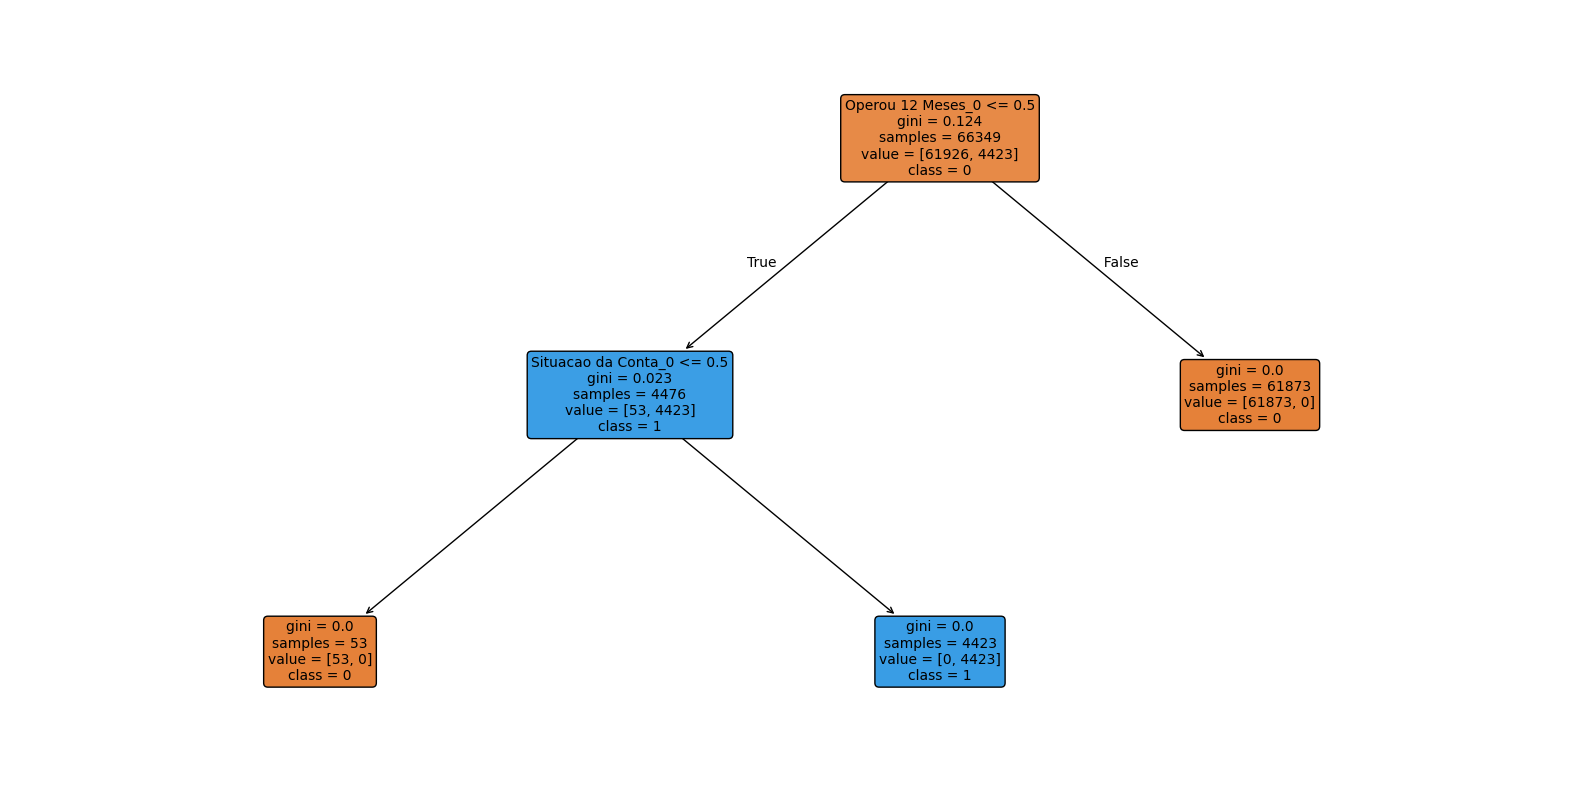

In [89]:
# Pegando os nomes das colunas geradas pelo OneHotEncoder
ohe = ct.named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)

# Pegando as colunas que não foram transformadas
non_categorical_cols = [col for col in X.columns if col not in categorical_cols]

# Unindo todas
feature_names = list(ohe_feature_names) + non_categorical_cols


from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(
    dt, 
    feature_names=feature_names,
    class_names=[str(c) for c in sorted(y.unique())],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.show()


## Analise de modelos

/tmp/ipykernel_2337939/1975812997.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


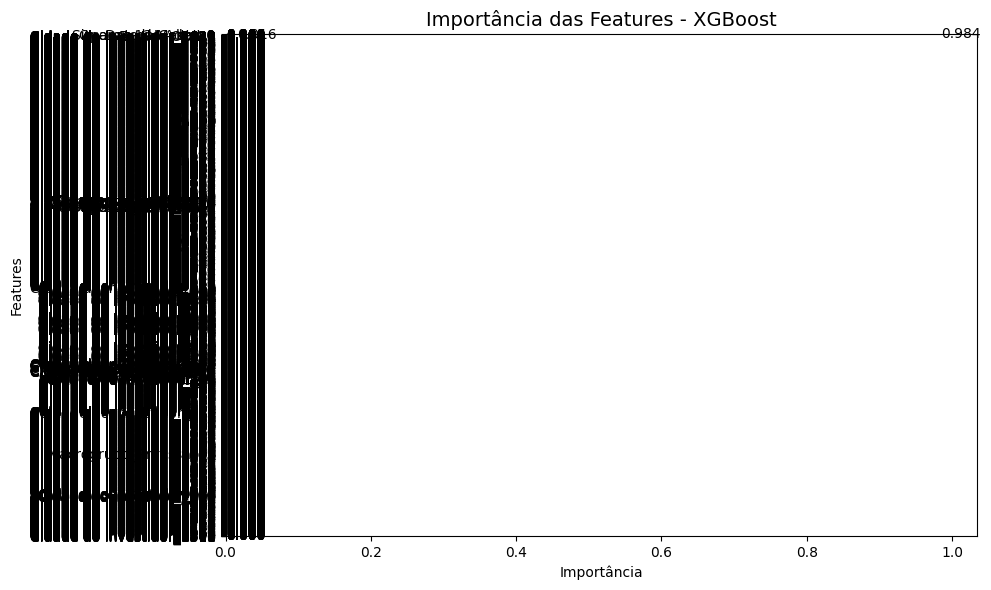

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Importância das características
importances = xgb.feature_importances_
features = X.columns

# Cria um DataFrame ordenado
df_importance = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='Importance',
    y='Feature',
    data=df_importance,
    palette='Blues_d'
)

plt.title('Importância das Features - XGBoost', fontsize=14)
plt.xlabel('Importância')
plt.ylabel('Features')

# Adicionando os valores nas barras
for p in ax.patches:
    width = p.get_width()
    plt.text(
        width + 0.001,                # posição X
        p.get_y() + p.get_height() / 2, # posição Y centralizado na barra
        f'{width:.3f}',                # valor formatado com 3 casas decimais
        va='center'
    )

plt.tight_layout()
plt.show()


## Z - TESTES Com codigo original

In [ ]:
df = pd.read_parquet("./data/to_classify/sample_data_cluster.parquet") 

In [48]:
# Encoding de variáveis categóricas (transformado em numeros inteiros)
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

X = df.drop(columns=['Operou 12 Meses'])
y = df['Operou 12 Meses']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #70% Treino e 30%Teste

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

# Decision Tree
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)
pred_dt = dt.predict(X_test)
print("Treinamento com arvore de decisao finalizado")

# Random Forest
rf = RandomForestClassifier(n_estimators=100,max_depth=3)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print("Treinamento com arvore de decisao aleatoria finalizado")

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss',n_estimators=100,max_depth=3,learning_rate=0.2, tree_method='gpu_hist')
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
print("Treinamento com XGBOOST finalizado")

# CatBoost
# cb = CatBoostClassifier(verbose=0, task_type="GPU")
# cb.fit(X_train, y_train)
# pred_cb = cb.predict(X_test)
# print("Treinamento com CATBOOST finalizado")

# Avaliação
print("Acurácia Decision Tree:", accuracy_score(y_test, pred_dt))
print("Acurácia Random Forest:", accuracy_score(y_test, pred_rf))
print("Acurácia XGBoost:", accuracy_score(y_test, pred_xgb))
# print("Acurácia CatBoost:", accuracy_score(y_test, pred_cb))

#Será que 90% é bom? Vamos analisar com mais detalhes os resultados a seguir.

Treinamento com arvore de decisao finalizado
Treinamento com arvore de decisao aleatoria finalizado


/home/fbrodrigues@FAZENDA.MS/teste/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:52:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/fbrodrigues@FAZENDA.MS/teste/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:52:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Treinamento com XGBOOST finalizado
Acurácia Decision Tree: 0.9303977137262257
Acurácia Random Forest: 0.9303977137262257
Acurácia XGBoost: 0.9303977137262257


/home/fbrodrigues@FAZENDA.MS/teste/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [15:52:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


/tmp/ipykernel_2113303/510692250.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<module 'matplotlib.pyplot' from '/home/fbrodrigues@FAZENDA.MS/teste/.venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

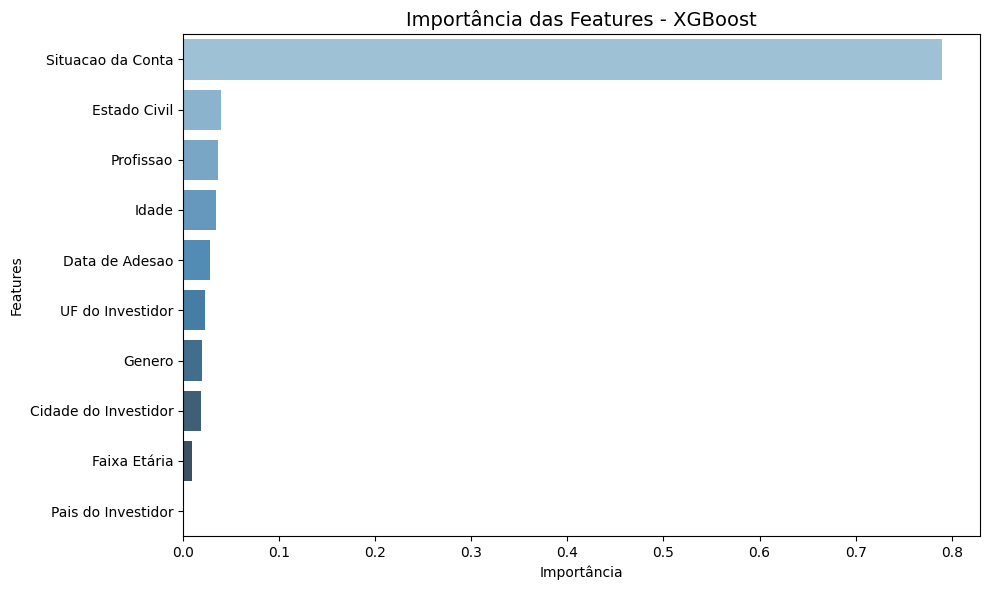

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Importância das características - XGBoost (você colocou 'Random Forest' no título, mas está usando xgb)
importances = xgb.feature_importances_
features = X.columns

# Cria um DataFrame para facilitar a ordenação
df_importance = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Ordena de maior para menor
df_importance = df_importance.sort_values(by='Importance', ascending=False)

# Plotando
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=df_importance,
    palette='Blues_d'
)
plt.title('Importância das Features - XGBoost', fontsize=14)
plt.xlabel('Importância')
plt.ylabel('Features')
plt.tight_layout()
plt
